In [1]:
%pylab inline
plt.rcParams['figure.figsize'] = (25, 10)

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.filters import gaussian_filter, sobel_filter
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree,
    plot_signal_histogram, earth_plot)

# Settings

In [8]:
#data_folder = Path("/mnt/Knolselderij/bulk/Abrupt/")
data_folder = Path("/mnt/D_DRIVE/datamining/edges/obsscan")
data_set = DataSet([data_folder / 'ice_conc_nh_ease2-250_cdr-v2p0.nc_remapbilt100.nc'], 'ice_conc')


#dataset goes from July 1981 - Dec 2011

sigma_d = unit('250 km')
sigma_t = unit('5 year')

month=7

gamma = 1000000
scaling_factor = gamma * unit('1 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [9]:
box = data_set.box

In [10]:
box.time_start

datetime.date(1978, 1, 1)

## Load the data

In [11]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(7233.91 year, 131.234 km, 125.094 km) per pixel
1979-01-30, 1979-02-27, 1979-03-31,  ...
time steps: max 8121600.0 min 172800.0


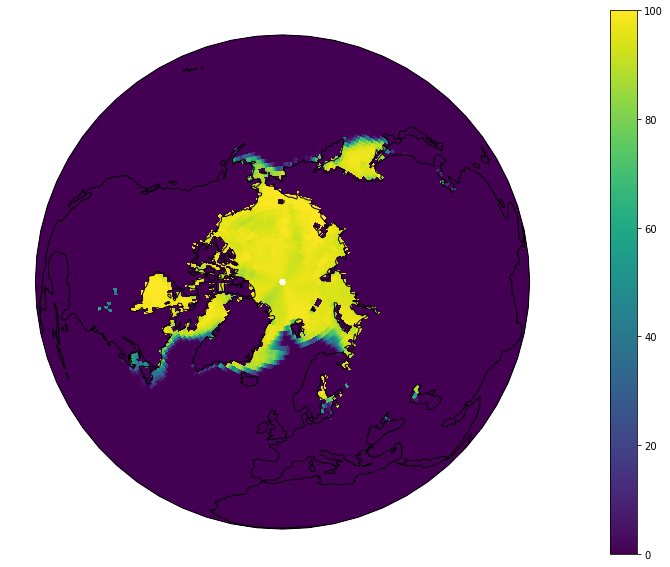

In [13]:
plot_orthographic_np(box, data_set.data[1])

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [14]:
yearly_data_set = data_set[month-1::12]
box = yearly_data_set.box
data = yearly_data_set.data

smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [15]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)

### Determine proper hysteresis settings

In [16]:
signal = 1/sb[3]

In [19]:
upper_threshold=100000
lower_threshold=1000

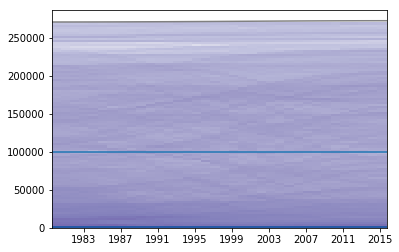

In [20]:
plot_signal_histogram(box, signal,upper_threshold,lower_threshold);

In [21]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [24]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
dat[:,:,:,3] = sb[3].transpose([2,1,0])
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

TypeError: only size-1 arrays can be converted to Python scalars

In [23]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

NameError: name 'mask' is not defined

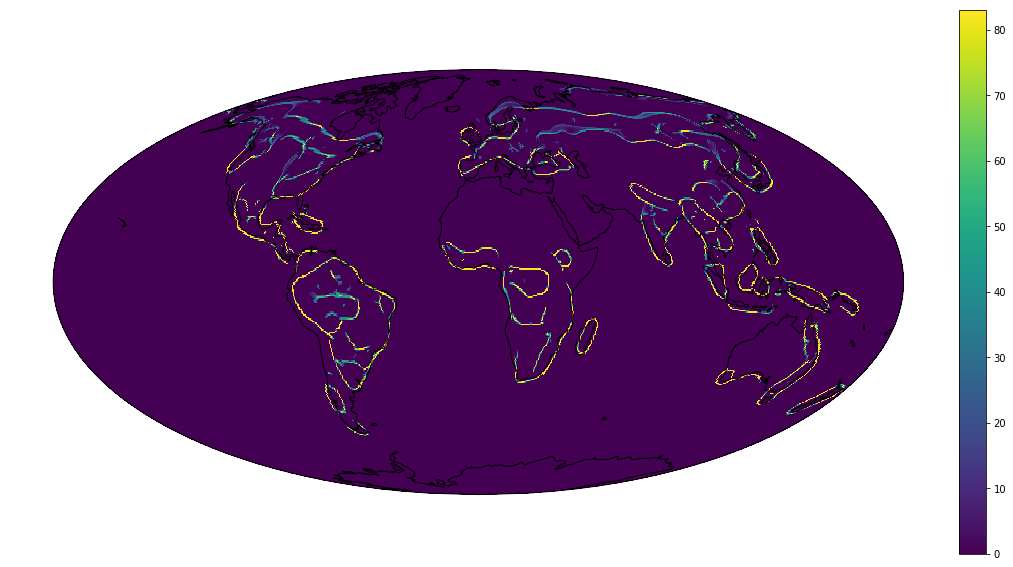

In [25]:
#earth_plot(
#    box, m.sum(axis=0),
#    projection=ccrs.Mollweide(
#        central_longitude=0,
#        central_latitude=0))

plot_mollweide(box, m.sum(axis=0))

In [26]:
labels, n_features = ndimage.label(m, ndimage.generate_binary_structure(3, 3))
print(n_features)
big_enough = [x for x in range(1, n_features+1) if (labels==x).sum() > 1]
print(big_enough)
labels = np.where(np.isin(labels, big_enough), labels, 0)

162
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162]


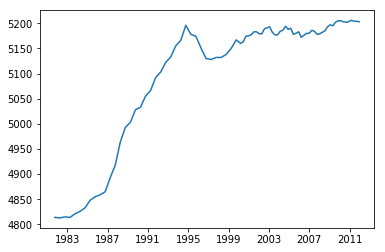

In [27]:
plt.plot(box.dates, m.sum(axis=1).sum(axis=1))
plt.show()